## Bandit-IV

In [1]:
import numpy as np
import numpy.random as ra
import numpy.linalg as la
from tqdm import tqdm
import matplotlib.pyplot as plt
# import os
# print(os.getcwd())

In [72]:
colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']
s_colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

In [486]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def pos_def_norm(x, A):
    if not is_pos_def(A): 
        raise ValueError
    return np.sqrt(x.T @ A @ x)

def get_synthetic_data(nb_exp, T): 
    S, sigma_1, sigma_2 = 1, 0.01, 0.0001
    # nb_exp, T, n_a, d = 100, int(1e3), 100, 20

    n_a = 5
    d = 6
    k = 7

    Gamma_star = ra.randn(k,d); #  theta_star *= 1/np.linalg.norm(theta_star) #maybe this can be changed
    # inv_theta_star = np.linalg.inv(Beta_star)
    Beta_star = ra.multivariate_normal([10 for i in range(d)], np.eye(d)).reshape(-1,) ;
    Beta_star *= S/np.linalg.norm(Beta_star)

    lamda = 1 ; lamda_IV = 1e-3
    delta = 0.001
    seed = 1996
    S_hat = S
    pulled_indeces = np.zeros((nb_exp,T))

    algorithms = ['banditiv']

    # FIRST STAGE
    # X_max = 100
    Z = ra.randn(nb_exp, T, n_a, k) #; Z /= np.max(np.linalg.norm(Z,axis=2))/X_max
    eps = sigma_1*ra.randn(nb_exp, T, n_a, d)
    # eps = np.zeros((T,d))

    X = np.dot(Z, Gamma_star) + eps

    # SECOND STAGE
    X = X / np.max(np.linalg.norm(X, axis=3, keepdims = True), axis=2, keepdims=True) 

    ee = d//4
    eta_tilde = ra.randn(nb_exp, T, n_a) 
    # eta = (eta_tilde + np.sum(eps[:,:,:,:ee]))/(1+ee*sigma_1)*sigma_2
    eta = sigma_2 * (eta_tilde + eps[:,:,:,:ee].sum(axis=-1))
    Y = np.dot(X, Beta_star) + eta

    Lz = np.max(np.linalg.norm(Z, axis=-1), axis=-1)
    Lx = np.max(np.linalg.norm(X, axis=-1), axis=-1)
    Ly = np.max(np.abs(Y), axis=-1)


    gamma_x, gamma_z = 0.01, 0.01
    delta = 0.0001

    Lz = np.max(np.linalg.norm(Z, axis=-1), axis=-1)
    Lx = np.max(np.linalg.norm(X, axis=-1), axis=-1)
    Ly = np.max(np.abs(Y), axis=-1)

    G_t = np.sqrt(gamma_z) * np.linalg.norm(Gamma_star,
                                            ord=2,axis=-2) #norm over rows
    b = np.sqrt(2*np.log(2*T / delta) + k*np.log((5*T*Ly**2)/k))[...,None]

    G_t = np.tile(G_t, (nb_exp, T, 1)) + b
        
    B_t = np.sqrt(gamma_x)*np.linalg.norm(Beta_star,ord=2) \
         + np.sqrt((2*np.log(2*T / delta)) + d*np.log((5*T*Lx**2)/d))

    return Z, X, Y, Gamma_star, Beta_star, Lz, Lx, Ly, G_t, B_t, gamma_z, gamma_x

T = 1000
nb_exp = 10
_ = get_synthetic_data(nb_exp, T)

In [490]:
def get_synthetic_data2(nb_exp, T):
    S, sigma_1, sigma_2 = 1, 0.01, 0.0001
    n_a, d = 10, 10
    k=d

    gamma_star = np.random.randn(d,d); #  theta_star *= 1/np.linalg.norm(theta_star) #maybe this can be changed
    inv_theta_star = np.linalg.inv(gamma_star)
    beta_star = np.random.multivariate_normal([10 for i in range(d)], np.eye(d)).reshape(-1,) ; beta_star *= S/np.linalg.norm(beta_star)

    lamda = 1 ; lamda_IV = 1e-3
    delta = 0.001
    seed = 1996
    S_hat = S
    # FIRST STAGE
    # X_max = 100
    Z = np.random.randn(nb_exp, T, n_a, d) #; Z /= np.max(np.linalg.norm(Z,axis=2))/X_max
    eps = sigma_1*np.random.randn(nb_exp, T, n_a, d)
    # eps = np.zeros((T,d))
    X = np.dot(Z, gamma_star) + eps

    # SECOND STAGE
    ee = d//4
    eta_tilde = np.random.randn(nb_exp, T, n_a) 
    # eta = (eta_tilde + np.sum(eps[:,:,:,:ee]))/(1+ee*sigma_1)*sigma_2
    eta = sigma_2 * (eta_tilde + eps[:,:,:,:ee].sum(axis=-1))
    X = X / np.max(np.linalg.norm(X, axis=3, keepdims = True), axis=2, keepdims=True) 
    Y = np.dot(X, beta_star) + eta

    gamma_x, gamma_z = 0.01, 0.01
    delta = 0.01

    Lz = np.max(np.linalg.norm(Z, axis=-1), axis=-1)
    Lx = np.max(np.linalg.norm(X, axis=-1), axis=-1)
    Ly = np.max(np.abs(Y), axis=-1)

    G_t = np.sqrt(gamma_z) * np.linalg.norm(gamma_star,
                                            ord=2,axis=-2) #norm over rows
    b = np.sqrt(2*np.log(2*T / delta) + k*np.log((5*T*Ly**2)/k))[...,None]

    G_t = np.tile(G_t, (nb_exp, T, 1)) + b
        
    B_t = np.sqrt(gamma_x)*np.linalg.norm(beta_star,ord=2) \
            + np.sqrt((2*np.log(2*T / delta)) + d*np.log((5*T*Lx**2)/d))

    return Z, X, Y, gamma_star, beta_star, Lz, Lx, Ly, G_t, B_t, gamma_z, gamma_x
    
T = 1000
nb_exp = 10
_ = get_synthetic_data2(nb_exp, T)

In [472]:
Z, X, Y, Gamma_star, Beta_star, Lz, Lx, Ly, G_t, B_t, gamma_z, gamma_x = get_synthetic_data(nb_exp,T)
print(Z.shape)
print(X.shape)
print(Y.shape)

(100, 10, 5, 7)
(100, 10, 5, 6)
(100, 10, 5)


In [496]:
def runit(nb_exp, T):

      ra.seed(42)
      Z_dist, X_dist, Y_dist, Gamma_star, Beta_star, Lz, Lx, Ly, G_t, B_t, gamma_z, gamma_x = get_synthetic_data2(nb_exp, T)

      nb_exp, T, nb_arms, d = X_dist.shape

      k = Z_dist.shape[-1]

      #result tracking
      regret = np.zeros((nb_exp,T))
      pred_norms = np.zeros((nb_exp,T))
      x_inv_norms = np.zeros((nb_exp,T))
      norm_beta_hat__beta = np.zeros((nb_exp, T))
      beta_hat_rec = np.zeros((nb_exp,T,d,1))
      GammaHat_rec = np.zeros((nb_exp,T, k, d))
      pulled_idx = np.zeros((nb_exp, T))

      for it in tqdm(range(nb_exp)): 

            #intializing estimated parameter matrics
            U_0 = np.eye(k)*gamma_z         # k x k
            V_0 = np.zeros((k,d))           # k x d
            W_0 = np.eye(d)*gamma_x         # d x d
            Q_0 = np.zeros((d,1))           # d x 1

            #initial pull 
            idx = ra.choice(np.arange(Z_dist.shape[2])) 

            # observe reward from pull (y is generated from gamma star)
            z = Z_dist[it][0][idx] ; x = X_dist[it][0][idx] ; y = Y_dist[it][0][idx]
            z = z[...,None] ; x = x[...,None] ; y = y[...,None]
            Z = z.T ; X = x.T ; Y = y.T

            y_star = np.max(Y_dist[0,0])  
            regret[it, 0] = y_star - y

            for t in range(1,T):

                  U_t = U_0 + z @ z.T
                  V_t = V_0 + z @ x.T           
                  Gamma_est = la.inv(U_t) @ V_t          #shape : d x k


                  X_est = (Z @ Gamma_est)
                  # X_est = (Z.T @ Gamma_est).T          #shape : t x k

                  W_t = W_0 + X_est.T @ X_est                  
                  Q_t = Q_0 + (X_est.T @ Y)[...,None]   
                  Wt_inv = la.inv(W_t) ; Ut_inv = la.inv(U_t)
                  Beta_est = Wt_inv @ Q_t           #shape : k x 1

                  #nature reveals Z_t
                  Zt = Z_dist[it][t] ; Xt = X_dist[it][t] ; Yt = Y_dist[it][t]
                  y_star = np.max(Yt)

                  objective = np.zeros(Zt.shape[0])
                  eigvals, _ = la.eig(Wt_inv)
                  for i, z_ in enumerate(Zt): 
                        A = np.sum([
                                    Beta_est.squeeze()[j] * np.dot(Gamma_est[:,j], z_) + G_t[it,t,j]* pos_def_norm(z_, Ut_inv)
                                          for j in range(Beta_est.shape[-1])
                                    ])
                        b = np.vstack([
                                    np.dot(Gamma_est[:,j], z_) + G_t[it,t,j]* pos_def_norm(z_, Ut_inv)
                                          for j in range(Beta_est.shape[-1])
                                    ])
                        B = (b.T @ b).squeeze() * np.max(eigvals)
                        objective[i] = A + np.sqrt(B)

                  idx = np.argmax(objective)
                  z = Zt[idx][...,None] ; x = Xt[idx][...,None]; y = Yt[idx][...,None]

                  Z = np.hstack([Z.T, z]).T
                  X = np.hstack([X.T, x]).T
                  Y = np.hstack([Y.T, y]).T

                  pulled_idx[it, t] = idx
                  regret[it, t] = y_star - y


                  beta_hat_rec[it, t] = Beta_est
                  GammaHat_rec[it,t] = Gamma_est


      return regret, beta_hat_rec, GammaHat_rec

T = 100
nb_exp = 10
regret, beta_hat_rec, GammaHat_rec = runit(nb_exp, T)

#     return regret, pred_norms, x_inv_norms, beta_hat_rec, ThetaHat_rec, norm_beta_hat__beta

  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/xw/wbth19cj4pj2bjqf4kf29jpm0000gn/T/ipykernel_50328/435656482.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  objective[i] = A + np.sqrt(B)
100%|██████████| 10/10 [00:02<00:00,  3.62it/s]


In [482]:
print(regret.shape)

(100, 1000)


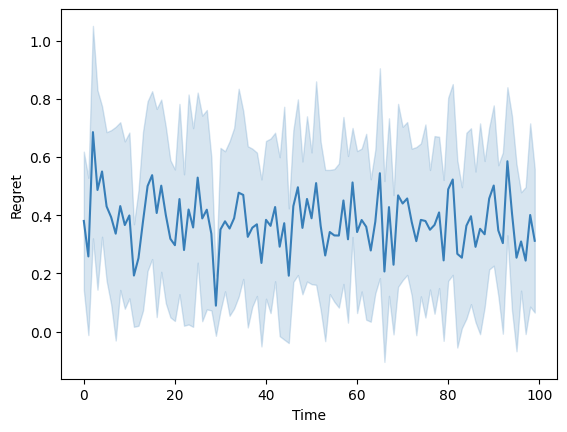

In [495]:
mean_regret = np.mean(regret, axis=0)
std_regret = np.std(regret, axis=0)


plt.plot(np.arange(mean_regret.shape[0]), mean_regret, color=colors[0])
plt.fill_between(np.arange(mean_regret.shape[0]), mean_regret - std_regret, mean_regret + std_regret, color=s_colors[0],alpha=0.2)
plt.xlabel("Time")
plt.ylabel('Regret')
plt.show()


In [ ]:
def sample1(Gamma_star, Beta_star, nb_arms, k, d): 
    # Construct Z,X
    e = ra.randn(nb_arms,1)                                           #endogenous component of X. 
    Z_dist = ra.randn(nb_arms, k)                                     #instrumental variable. K arms. Related to X but exogenous wrt Y

    # rho = 1-2*np.random.binomial(1, 0.2) #random noise scaler for Y
    u = ra.randn(nb_arms,d)

    X_dist = (Gamma_star.T @ Z_dist[...,None]).squeeze() + u  # d  (IV + exogenous component + endogenous component)

    v = (Beta_star.T @ u.T).T
    Y_dist = ((Gamma_star @ Beta_star).T @ Z_dist.T).T + v
    return (Z_dist,
            X_dist,
            Y_dist.squeeze())

def construct_dataset(nb_exp, T): 
    k = 6
    d = 6
    nb_arms = 5

    Gamma_star = np.random.randn(k,d)   # arms x features
    Beta_star = np.random.randn(d,1)   

    Z_dist = np.zeros((nb_exp,T,nb_arms,k))
    X_dist = np.zeros((nb_exp,T,nb_arms,d))
    Y_dist = np.zeros((nb_exp,T,nb_arms))

    for it in range(nb_exp): 
        for t in range(T):
            r = sample1(Gamma_star, Beta_star, nb_arms, k, d)
            Z_dist[it][t] = r[0]
            X_dist[it][t] = r[1]
            Y_dist[it][t] = r[2]
    
    return Z_dist, X_dist, Y_dist, Gamma_star, Beta_star
